In [3]:
import pandas as pd
import os
import loc_utils


### Import clean data

df_langdetect.csv contains the information on the languages used in the df. However since the clean up might be better than when we originally did the classification We will first realign the two.



### Call DeepL for translations

In [5]:
if os.path.exists(loc_utils.deepl_file):
    df_translate = pd.read_csv(loc_utils.deepl_file)
    print('found deepL output file and will continue from there')
else:
    if os.path.exists('language_analysis/df_lang.csv'):
        print("found 'language_analysis/df_lang.csv', will not run text_cleaner")
        df_lang = pd.read_csv('language_analysis/df_lang.csv', index_col=0)
    else:
        print("did not found 'language_analysis/df_lang.csv', will run text_cleaner")
        df_lang = loc_utils.import_clean_data()
    df_translate = loc_utils.safe_create_column('deepL_translation', df_translate)
    df_translate.to_csv(loc_utils.deepl_file)
    print('creating deepL output file')

found deepL output file and will continue from there


DeepL has a free offering for their API which is restricted to 500,000 per month per account. Since we might not be able to simply translate everything, 
we want to start off understanding the elements that are not in French to evaluate which ones we want to translate first.

In [6]:
# getting some number to evaluate localization strategies
characters = int(df_translate.loc[(~df_translate['lang'].isin(loc_utils.ignore_language_codes)) & (df_translate['deepL_translation'].isna())]['merged_text'].str.len().sum())

DeepL_free_limit = 500000

print(f'We have {characters:,} characters that we still need to localize. Assuming that we use a free account of DeepL we would need {characters//DeepL_free_limit+1} accounts or months to localize everything into French')

We have 1,993,921 characters that we still need to localize. Assuming that we use a free account of DeepL we would need 4 accounts or months to localize everything into French


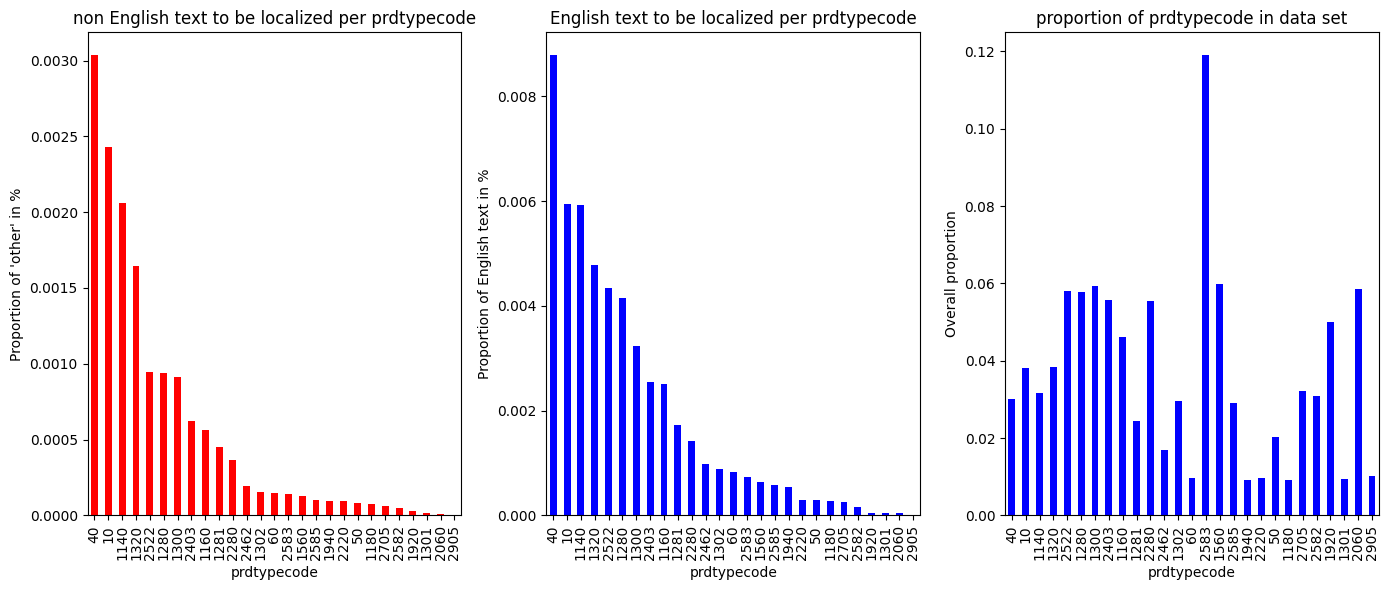

In [15]:
import matplotlib.pyplot as plt 
freq_counts = pd.crosstab(df_translate['prdtypecode'], df_translate.loc[df_translate['deepL_translation'].isna()]['lang'].apply(lambda x: x if x in ['fr', 'en'] else 'other'), normalize=True)

# Compute "other" proportion per prdtypecode
other_freq = freq_counts['other'].sort_values(ascending=False)

en_freq = freq_counts['en'].sort_values(ascending=False)

# Compute overall proportion of each prdtypecode
overall_freq = df_translate['prdtypecode'].value_counts(normalize=True)

# Reindex `overall_freq` to match the order of `other_freq`
overall_freq = overall_freq.reindex(other_freq.index, fill_value=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

# Plot proportion of "other" per prdtypecode
other_freq.plot(kind="bar", color="red", ax=axes[0])
axes[0].set_title("non English text to be localized per prdtypecode")
axes[0].set_xlabel("prdtypecode")
axes[0].set_ylabel("Proportion of 'other' in %")

# Plot overall proportion of each prdtypecode (same order)
en_freq.plot(kind="bar", color="blue", ax=axes[1])
axes[1].set_title("English text to be localized per prdtypecode")
axes[1].set_xlabel("prdtypecode")
axes[1].set_ylabel("Proportion of English text in %")

# Plot overall proportion of each prdtypecode (same order)
overall_freq.plot(kind="bar", color="blue", ax=axes[2])
axes[2].set_title("proportion of prdtypecode in data set")
axes[2].set_xlabel("prdtypecode")
axes[2].set_ylabel("Overall proportion")

# Adjust layout
plt.tight_layout()
plt.show();

### Calling the DeepL API

The DeepL documentation used for this can be found https://developers.deepl.com/docs/getting-started/your-first-api-request

In [31]:
try:
    df_translate = loc_utils.apply_translation_conditionally_in_chunks(df_translate, chunk_size=200)
    df_translate.to_csv(loc_utils.deepl_file, index=False)
    print('{loc_utils.deepl_file} was updated')
except Exception as e:
    df_deepL_output = pd.read_csv(loc_utils.deepl_output_file, index_col='productid').drop_duplicates()
    df_translate = df_translate.set_index('productid')
    df_translate.combine_first(df_deepL_output).to_csv(loc_utils.deepl_file)
    print(f'Error: {e} \n\
          updating {loc_utils.deepl_file} from {loc_utils.deepl_output_file}')
    


85916 rows left to run
85716 rows left to run
85516 rows left to run
85316 rows left to run


KeyError: "None of ['productid'] are in the columns"

In [38]:
df_translate.to_csv(loc_utils.deepl_file)

In [36]:
df_ID = pd.read_csv('X_train.csv', index_col = 0)
df_ID = df_ID[['productid', 'imageid']]
df_ID.head()

,productid,imageid
0,3804725264,1263597046
1,436067568,1008141237
2,201115110,938777978
3,50418756,457047496
4,278535884,1077757786


In [ ]:
df_translate